# 5a. Full workflow: Marianas arc data

Here's an example of a full workflow to explore melt inclusion and matrix glass data using VolFe. We'll calculate saturation pressures, degassing paths, isobars, and *f*<sub>O<sub>2</sub></sub> from sulfur content from a single csv file in one notebook. This example is used in Hughes et al. (pre-print).

## Python set-up
First we need to import a few Python packages (including VolFe). You need to install VolFe (and the other packages such as ThermoBar) once on your machine. If you haven't yet, uncomment the line below (remove the # for the lines beginning !pip).

In [1]:
# Install VolFe and Thermobar on your machine if you have not done so already. Remove the # from lines below to do this (don't remove the # from this line!).
# !pip install VolFe
# !pip install Thermobar

In [2]:
# import python packages
import pandas as pd
import numpy as np
import VolFe as vf
import Thermobar as tb
import matplotlib.pyplot as plt

## Import data

First we will load our data from a csv file. We'll use the examples_marianas csv in files again from Brounce et al. (2014, 2016) and Kelley & Cottrell (2012).

In [3]:
my_analyses = pd.read_csv("../files/example_marianas.csv")  # load data

## Calculate temperature using Thermobar

All VolFe calculations require a temperature. We calculate temperature for each glass analysis using eq. (14) from Putirka (2008), which depends on melt composition including water but not pressure, using ThermoBar (Wieser et al. 2022). This is then added to the dataframe of compositions.

In [4]:
# renames melt composition headers to be comparible with Thermobar
my_analyses_tb = my_analyses.rename(columns = {"SiO2":"SiO2_Liq","TiO2":"TiO2_Liq","Al2O3":"Al2O3_Liq","FeOT":"FeOt_Liq","MnO":"MnO_Liq","MgO":"MgO_Liq","CaO":"CaO_Liq",
                                               "Na2O":"Na2O_Liq","K2O":"K2O_Liq","P2O5":"P2O5_Liq","H2O":"H2O_Liq"})
# calculates T using Thermobar based on eq. (14) from Putirka (2008) and converts to 'C
T_C_all = tb.calculate_liq_only_temp(liq_comps=my_analyses_tb, equationT="T_Put2008_eq14")-273.15
# adds temperatures to original dataframe
my_analyses.insert(1,"T_C",T_C_all)

## Calculate the pressure of vapor-saturation

Now we can calculate the pressure of vapor saturation for all the analyses in the file using the default models in VolFe.

In [5]:
pvsat = vf.calc_Pvsat(my_analyses)

## Calculate the *f*<sub>O<sub>2</sub></sub> from the sulfur content

Instead of using the Fe<sup>3+</sup>/Fe<sub>T</sub> measured in the glass to calculate *f*<sub>O<sub>2</sub></sub>, we can instead use the measured S content and compare it too the S<sup>2-</sup>CSS.

In [6]:
fO2fromS = vf.calc_melt_S_oxybarometer(my_analyses)

## Influence of melt composition errors

Next we look at how errors in the melt composition might influence the calculations we have done. We use the composition of melt inclusion Ala02-16A. Next we use a Monte Carlo approach to calculate 1000 potential compositions of Ala02-16A to see how that effects our calculations.

In [7]:
comp_error = vf.calc_comp_error(my_analyses,29,1000)

We can work out the temperature associated with each melt composition again using eq. (14) from Putirka (2008) using ThermoBar (Wieser et al. 2022). First we have to change the header and then add the results to the dataframe of compositions.

In [8]:
# removes the first three rows that detail the original composition, the error size, and its type
comp_error = comp_error.drop([1,2,3]) 
# reset the index so the first row is 0 again
comp_error = comp_error .reset_index() 
# remove the current temperature value
comp_error = comp_error.drop(['T_C'], axis=1) 
# rename the columns so it is compatible with Thermobar
comp_error_tb = comp_error.rename(columns = {"SiO2":"SiO2_Liq","TiO2":"TiO2_Liq","Al2O3":"Al2O3_Liq","FeOT":"FeOt_Liq","MnO":"MnO_Liq","MgO":"MgO_Liq","CaO":"CaO_Liq",
                                               "Na2O":"Na2O_Liq","K2O":"K2O_Liq","P2O5":"P2O5_Liq","H2O":"H2O_Liq"})
# calculate the temperature and convert to 'C
T_C_error = tb.calculate_liq_only_temp(liq_comps=comp_error_tb, equationT="T_Put2008_eq14")-273.15
# add the temperatures to the dataframe
comp_error.insert(1,"T_C",T_C_error)

c:\Users\ehughes\AppData\Local\miniforge3\envs\volfe-dev\Lib\site-packages\Thermobar\core.py:474: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oxide_mass_liq_anhyd_df.columns, axis=1).fillna(0)
c:\Users\ehughes\AppData\Local\miniforge3\envs\volfe-dev\Lib\site-packages\Thermobar\core.py:474: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oxide_mass_liq_anhyd_df.columns, axis=1).fillna(0)


Next we calculate the *P<sup>v</sup>*<sub>sat</sub> for each composition. After, we calculate the mean and standard deviation for *T*, *P<sup>v</sup>*<sub>sat</sub>, *P<sup>v</sup>*<sub>sat</sub>_diff, and *f*<sub>O<sub>2</sub></sub> using the measured Fe<sup>3+</sup>/Fe<sub>T</sub>.

In [9]:
pvsat_error = vf.calc_Pvsat(comp_error)

In [10]:
pvsat_stats = {"T_mean":np.mean(pvsat_error["T_C"]),"T_sd":np.std(pvsat_error["T_C"]),
               "P_mean":np.mean(pvsat_error["P_bar"]),"P_sd":np.std(pvsat_error["P_bar"]),
               "fO2_mean":np.mean(pvsat_error["fO2_DFMQ"]),"fO2_sd":np.std(pvsat_error["fO2_DFMQ"]),
               "P_diff_mean":np.mean(pvsat_error["Pvsat_diff_bar"]),"P_diff_sd":np.std(pvsat_error["Pvsat_diff_bar"])}

And a similar analysis for *f*<sub>O<sub>2</sub></sub> from measured S.

In [11]:
fO2fromS_error = vf.calc_melt_S_oxybarometer(comp_error)

In [12]:
fO2fromS_stats = {"fO2_mean":np.mean(fO2fromS_error["DFMQ-sulfide"]),"fO2_sd":np.std(fO2fromS_error["DFMQ-sulfide"]),
               "P_mean":np.mean(fO2fromS_error["P (bar) sulf"]),"P_sd":np.std(fO2fromS_error["P (bar) sulf"])}

## Calculate isobars

We can also calculate isobars for Ala02-16A but we need to change the "insolubles" option to "H2O-CO2 only" to do this.

In [13]:
# change just the "COH_species" option to "H2O-CO2 only"
my_models = [['COH_species','H2O-CO2 only']]
# turn "my_models" to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)
# calculate isobars for Ala01-16A which is run 29 in the csv starting at 1000 bars, ending at 4000 bars at 1000 bar intervals
isobars = vf.calc_isobar(my_analyses,run=29,models=my_models,initial_P=1000.,final_P=5000.,step_P=1000.)
# split into each pressure for plotting
isobar1000 = isobars[isobars["P_bar"]==1000.]
isobar2000 = isobars[isobars["P_bar"]==2000.]
isobar3000 = isobars[isobars["P_bar"]==3000.]
isobar4000 = isobars[isobars["P_bar"]==4000.]
isobar5000 = isobars[isobars["P_bar"]==5000.]

## Calculate de/regassing paths

Next we can run a closed-system degassing calculation starting from Ala02-16A, using the default options.

In [14]:
degassing_closed_1 = vf.calc_gassing(my_analyses,run=29)

1.0 : Switching solve species from OCS to OCH (first time)
1.0 : Switching solve species from OCH to OHS (second time)
1.0 : Switching solve species from OCS to OCH (first time)
1.0 : Switching solve species from OCH to OHS (second time)
solver failed, calculation aborted at P =  1.0 2025-02-02 12:28:49.510892


But it probably had more CO<sub>2</sub> to start with... so we can run a closed-system degassing calculation assuming the initial melt contained 2 wt% CO<sub>2</sub>.

In [15]:
# 'bulk composition' to 'melt+vapor_initialCO2'
my_models = [['bulk_composition',"melt+vapor_initialCO2"]]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

degassing_closed_2 = vf.calc_gassing(my_analyses,run=29,models=my_models)

1.0 : Switching solve species from OCS to OCH (first time)
1.0 : Switching solve species from OCH to OHS (second time)
1.0 : Switching solve species from OCS to OCH (first time)
1.0 : Switching solve species from OCH to OHS (second time)
solver failed, calculation aborted at P =  1.0 2025-02-02 12:29:38.895658


... and regas along the same path to see how it would have evolved at higher pressures before the melt inclusion was formed.

In [ ]:
# change to regas and melt+vapor_initialCO2
my_models = [['gassing_direction','regas'],['bulk_composition',"melt+vapor_initialCO2"]]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

regassing_closed_2 = vf.calc_gassing(my_analyses,run=29,models=my_models)

And we can compare it to open-system degassing...

In [17]:
# change just the "COH_species" option to "H2O-CO2 only"
my_models = [['gassing_style','open']]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

degassing_open = vf.calc_gassing(my_analyses,run=29,models=my_models)

... and open-system regassing ...

In [18]:
# change just the "COH_species" option to "H2O-CO2 only"
my_models = [['gassing_style','open'],['gassing_direction','regas']]

# turn to dataframe with correct column headers and indexes    
my_models = vf.make_df_and_add_model_defaults(my_models)

regassing_open = vf.calc_gassing(my_analyses,run=29,models=my_models)

## Plotting

Finally, we can plot all everything!

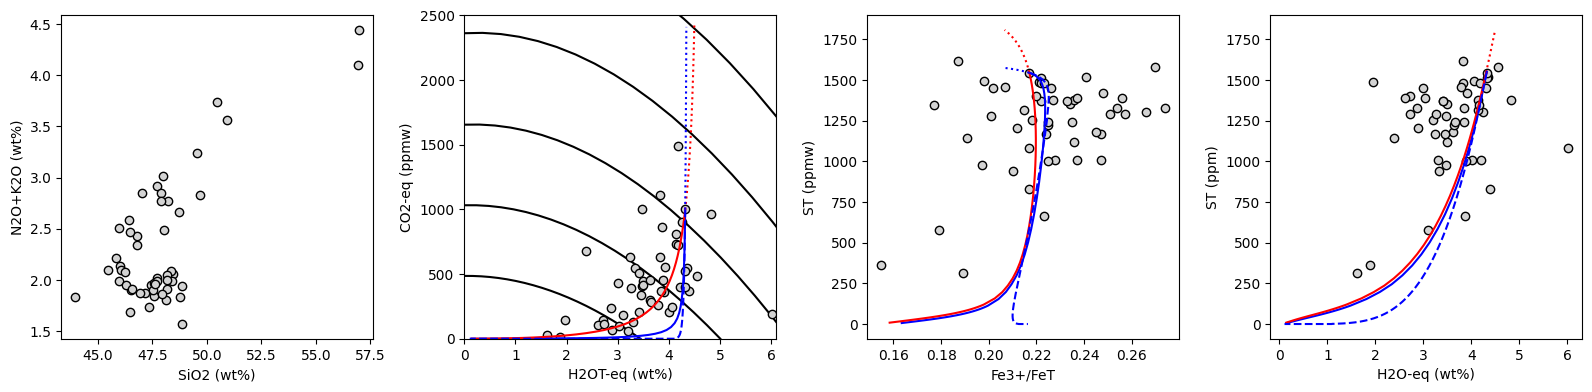

In [19]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))

# TAS
ax1.plot(my_analyses['SiO2'], my_analyses['K2O']+my_analyses['Na2O'],'ok', mfc='lightgrey')
ax1.set_ylabel('N2O+K2O (wt%)')
ax1.set_xlabel('SiO2 (wt%)')

# H2O-CO2
ax2.plot(isobar1000["H2O_wtpc"], isobar1000["CO2_ppm"], '-k')
ax2.plot(isobar2000["H2O_wtpc"], isobar2000["CO2_ppm"], '-k')
ax2.plot(isobar3000["H2O_wtpc"], isobar3000["CO2_ppm"], '-k')
ax2.plot(isobar4000["H2O_wtpc"], isobar4000["CO2_ppm"], '-k')
ax2.plot(isobar5000["H2O_wtpc"], isobar5000["CO2_ppm"], '-k')
ax2.plot(my_analyses['H2O'], my_analyses['CO2ppm'], 'ok', mfc='lightgrey')
ax2.plot(degassing_closed_1['H2OT-eq_wtpc'], degassing_closed_1['CO2T-eq_ppmw'], '-b')
ax2.plot(degassing_closed_2['H2OT-eq_wtpc'], degassing_closed_2['CO2T-eq_ppmw'], '-r')
ax2.plot(regassing_closed_2['H2OT-eq_wtpc'], regassing_closed_2['CO2T-eq_ppmw'], ':r')
ax2.plot(regassing_open['H2OT-eq_wtpc'], regassing_open['CO2T-eq_ppmw'], ':b')
ax2.plot(degassing_open['H2OT-eq_wtpc'], degassing_open['CO2T-eq_ppmw'], '--b')
ax2.set_xlabel('H2OT-eq (wt%)')
ax2.set_ylabel('CO2-eq (ppmw)')
ax2.set_ylim([0,2500])
ax2.set_xlim([0,6.1])

# Fe3+/FeT-ST
ax3.plot(my_analyses['Fe3FeT'], my_analyses['STppm'], 'ok', mfc='lightgrey')
ax3.plot(degassing_closed_1['Fe3+/FeT'], degassing_closed_1['ST_ppmw'], '-b')
ax3.plot(degassing_closed_2['Fe3+/FeT'], degassing_closed_2['ST_ppmw'], '-r')
ax3.plot(regassing_closed_2['Fe3+/FeT'], regassing_closed_2['ST_ppmw'], ':r')
ax3.plot(regassing_open['Fe3+/FeT'], regassing_open['ST_ppmw'], ':b')
ax3.plot(degassing_open['Fe3+/FeT'], degassing_open['ST_ppmw'], '--b')
ax3.set_xlabel('Fe3+/FeT')
ax3.set_ylabel('ST (ppmw)')
 

# H2O-ST
ax4.plot(my_analyses['H2O'], my_analyses['STppm'], 'ok', mfc='lightgrey')
ax4.plot(degassing_closed_1['H2OT-eq_wtpc'], degassing_closed_1['ST_ppmw'], '-b')
ax4.plot(degassing_closed_2['H2OT-eq_wtpc'], degassing_closed_2['ST_ppmw'], '-r')
ax4.plot(regassing_closed_2['H2OT-eq_wtpc'], regassing_closed_2['ST_ppmw'], ':r')
ax4.plot(regassing_open['H2OT-eq_wtpc'], regassing_open['ST_ppmw'], ':b')
ax4.plot(degassing_open['H2OT-eq_wtpc'], degassing_open['ST_ppmw'], '--b')
ax4.set_xlabel('H2O-eq (wt%)')
ax4.set_ylabel('ST (ppm)')
fig.tight_layout(pad=1.0)

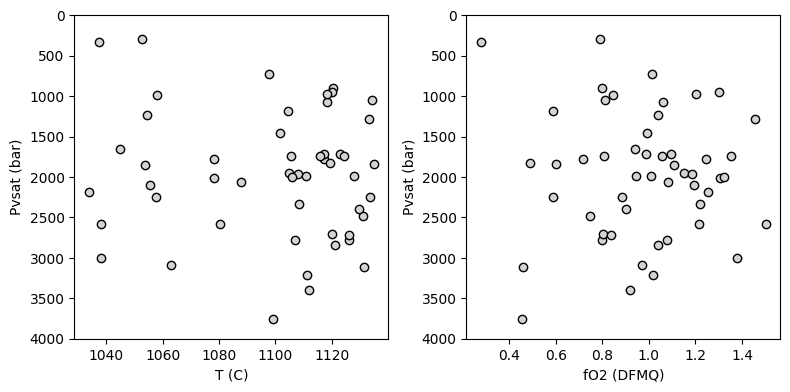

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))

# P-T
ax1.plot(pvsat['T_C'], pvsat['P_bar'],'ok', mfc='lightgrey')
ax1.set_ylabel('Pvsat (bar)')
ax1.set_xlabel('T (C)')
ax1.set_ylim([4000,0])

# P-fO2[Fe3+/FeT]
ax2.plot(pvsat['fO2_DFMQ'], pvsat['P_bar'],'ok', mfc='lightgrey')
ax2.set_ylabel('Pvsat (bar)')
ax2.set_xlabel('fO2 (DFMQ)')
ax2.set_ylim([4000,0])

fig.tight_layout(pad=1.0)

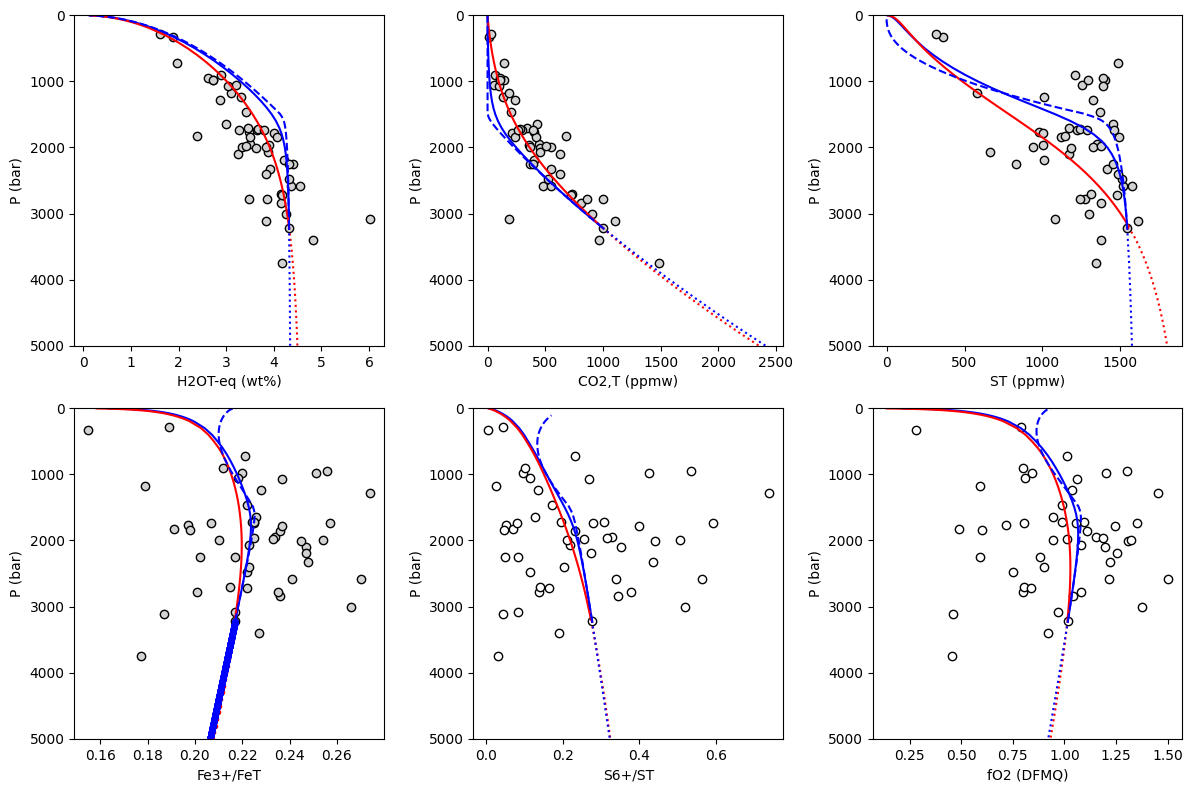

In [21]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(12,8))

# H2O-P
ax1.plot(pvsat['H2OT-eq_wtpc'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax1.plot(degassing_closed_1['H2OT-eq_wtpc'], degassing_closed_1['P_bar'], '-b')
ax1.plot(degassing_closed_2['H2OT-eq_wtpc'], degassing_closed_2['P_bar'], '-r')
ax1.plot(regassing_closed_2['H2OT-eq_wtpc'], regassing_closed_2['P_bar'], ':r')
ax1.plot(regassing_open['H2OT-eq_wtpc'], regassing_open['P_bar'], ':b')
ax1.plot(degassing_open['H2OT-eq_wtpc'], degassing_open['P_bar'], '--b')
ax1.set_xlabel('H2OT-eq (wt%)')
ax1.set_ylabel('P (bar)')
ax1.set_ylim([5000,0])

# CO2-P
ax2.plot(pvsat['CO2T-eq_ppmw'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax2.plot(degassing_closed_1['CO2T-eq_ppmw'], degassing_closed_1['P_bar'], '-b')
ax2.plot(degassing_closed_2['CO2T-eq_ppmw'], degassing_closed_2['P_bar'], '-r')
ax2.plot(regassing_closed_2['CO2T-eq_ppmw'], regassing_closed_2['P_bar'], ':r')
ax2.plot(regassing_open['CO2T-eq_ppmw'], regassing_open['P_bar'], ':b')
ax2.plot(degassing_open['CO2T-eq_ppmw'], degassing_open['P_bar'], '--b')
ax2.set_xlabel('CO2,T (ppmw)')
ax2.set_ylabel('P (bar)')
ax2.set_ylim([5000,0])

#ST-P
ax3.plot(pvsat['ST_ppmw'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax3.plot(degassing_closed_1['ST_ppmw'], degassing_closed_1['P_bar'], '-b')
ax3.plot(degassing_closed_2['ST_ppmw'], degassing_closed_2['P_bar'], '-r')
ax3.plot(regassing_closed_2['ST_ppmw'], regassing_closed_2['P_bar'], ':r')
ax3.plot(regassing_open['ST_ppmw'], regassing_open['P_bar'], ':b')
ax3.plot(degassing_open['ST_ppmw'], degassing_open['P_bar'], '--b')
ax3.set_xlabel('ST (ppmw)')
ax3.set_ylabel('P (bar)')
ax3.set_ylim([5000,0])

#Fe3+FeT-P
ax4.plot(pvsat['Fe3+/FeT'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax4.plot(degassing_closed_1['Fe3+/FeT'], degassing_closed_1['P_bar'], '-b')
ax4.plot(degassing_closed_2['Fe3+/FeT'], degassing_closed_2['P_bar'], '-r')
ax4.plot(regassing_closed_2['Fe3+/FeT'], regassing_closed_2['P_bar'], '.r')
ax4.plot(regassing_open['Fe3+/FeT'], regassing_open['P_bar'], '.b')
ax4.plot(degassing_open['Fe3+/FeT'], degassing_open['P_bar'], '--b')
ax4.set_xlabel('Fe3+/FeT')
ax4.set_ylabel('P (bar)')
ax4.set_ylim([5000,0])

#S6+/ST-P
ax5.plot(pvsat['S6+/ST'], pvsat['P_bar'], 'ok', mfc='white')
ax5.plot(degassing_closed_1['S6+/ST'], degassing_closed_1['P_bar'], '-b')
ax5.plot(degassing_closed_2['S6+/ST'], degassing_closed_2['P_bar'], '-r')
ax5.plot(regassing_closed_2['S6+/ST'], regassing_closed_2['P_bar'], ':r')
ax5.plot(regassing_open['S6+/ST'], regassing_open['P_bar'], ':b')
degassing_open2 = degassing_open[degassing_open['S6+/ST']!='']
ax5.plot(degassing_open2['S6+/ST'], degassing_open2['P_bar'], '--b')
ax5.set_xlabel('S6+/ST')
ax5.set_ylabel('P (bar)')
ax5.set_ylim([5000,0])

#DFMQ-P
ax6.plot(pvsat['fO2_DFMQ'], pvsat['P_bar'], 'ok', mfc='white')
ax6.plot(degassing_closed_1['fO2_DFMQ'], degassing_closed_1['P_bar'], '-b')
ax6.plot(degassing_closed_2['fO2_DFMQ'], degassing_closed_2['P_bar'], '-r')
ax6.plot(regassing_closed_2['fO2_DFMQ'], regassing_closed_2['P_bar'], ':r')
ax6.plot(regassing_open['fO2_DFMQ'], regassing_open['P_bar'], ':b')
ax6.plot(degassing_open['fO2_DFMQ'], degassing_open['P_bar'], '--b')
ax6.set_xlabel('fO2 (DFMQ)')
ax6.set_ylabel('P (bar)')
ax6.set_ylim([5000,0])

fig.tight_layout(pad=1.0)

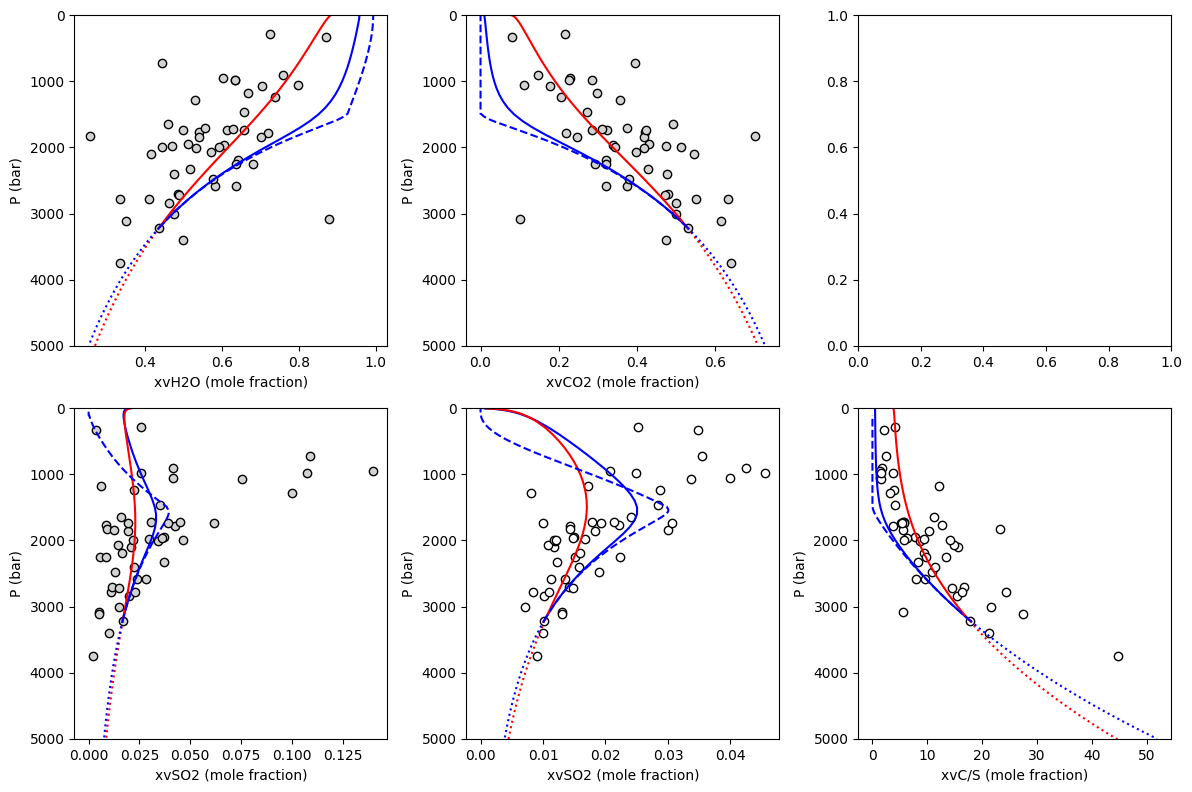

In [22]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(12,8))

# H2O-P
ax1.plot(pvsat['xgH2O_mf'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax1.plot(degassing_closed_1['xgH2O_mf'], degassing_closed_1['P_bar'], '-b')
ax1.plot(degassing_closed_2['xgH2O_mf'], degassing_closed_2['P_bar'], '-r')
ax1.plot(regassing_closed_2['xgH2O_mf'], regassing_closed_2['P_bar'], ':r')
ax1.plot(regassing_open['xgH2O_mf'], regassing_open['P_bar'], ':b')
ax1.plot(degassing_open['xgH2O_mf'], degassing_open['P_bar'], '--b')
ax1.set_xlabel('xvH2O (mole fraction)')
ax1.set_ylabel('P (bar)')
ax1.set_ylim([5000,0])

# CO2-P
ax2.plot(pvsat['xgCO2_mf'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax2.plot(degassing_closed_1['xgCO2_mf'], degassing_closed_1['P_bar'], '-b')
ax2.plot(degassing_closed_2['xgCO2_mf'], degassing_closed_2['P_bar'], '-r')
ax2.plot(regassing_closed_2['xgCO2_mf'], regassing_closed_2['P_bar'], ':r')
ax2.plot(regassing_open['xgCO2_mf'], regassing_open['P_bar'], ':b')
ax2.plot(degassing_open['xgCO2_mf'], degassing_open['P_bar'], '--b')
ax2.set_xlabel('xvCO2 (mole fraction)')
ax2.set_ylabel('P (bar)')
ax2.set_ylim([5000,0])

#SO2-P
ax4.plot(pvsat['xgSO2_mf'], pvsat['P_bar'], 'ok', mfc='lightgrey')
ax4.plot(degassing_closed_1['xgSO2_mf'], degassing_closed_1['P_bar'], '-b')
ax4.plot(degassing_closed_2['xgSO2_mf'], degassing_closed_2['P_bar'], '-r')
ax4.plot(regassing_closed_2['xgSO2_mf'], regassing_closed_2['P_bar'], ':r')
ax4.plot(regassing_open['xgSO2_mf'], regassing_open['P_bar'], ':b')
ax4.plot(degassing_open['xgSO2_mf'], degassing_open['P_bar'], '--b')
ax4.set_xlabel('xvSO2 (mole fraction)')
ax4.set_ylabel('P (bar)')
ax4.set_ylim([5000,0])

#H2S-P
ax5.plot(pvsat['xgH2S_mf'], pvsat['P_bar'], 'ok', mfc='white')
ax5.plot(degassing_closed_1['xgH2S_mf'], degassing_closed_1['P_bar'], '-b')
ax5.plot(degassing_closed_2['xgH2S_mf'], degassing_closed_2['P_bar'], '-r')
ax5.plot(regassing_closed_2['xgH2S_mf'], regassing_closed_2['P_bar'], ':r')
ax5.plot(regassing_open['xgH2S_mf'], regassing_open['P_bar'], ':b')
ax5.plot(degassing_open['xgH2S_mf'], degassing_open['P_bar'], '--b')
ax5.set_xlabel('xvSO2 (mole fraction)')
ax5.set_ylabel('P (bar)')
ax5.set_ylim([5000,0])

#CS-P
ax6.plot(pvsat['xgC_S_mf'], pvsat['P_bar'], 'ok', mfc='white')
ax6.plot(degassing_closed_1['xgC_S_mf'], degassing_closed_1['P_bar'], '-b')
ax6.plot(degassing_closed_2['xgC_S_mf'], degassing_closed_2['P_bar'], '-r')
ax6.plot(regassing_closed_2['xgC_S_mf'], regassing_closed_2['P_bar'], ':r')
ax6.plot(regassing_open['xgC_S_mf'], regassing_open['P_bar'], ':b')
degassing_open2 = degassing_open[degassing_open['xgC_S_mf']!='']
ax6.plot(degassing_open2['xgC_S_mf'], degassing_open2['P_bar'], '--b')
ax6.set_xlabel('xvC/S (mole fraction)')
ax6.set_ylabel('P (bar)')
ax6.set_ylim([5000,0])

fig.tight_layout(pad=1.0)

## Saving outputs

Saving all outputs to csv.

In [23]:
comp_error.to_csv('../files/marianas_comp_error.csv', index=False, header=True)
pvsat.to_csv('../files/marianas_pvsat.csv', index=False, header=True)
pvsat_error.to_csv('../files/marianas_pvsat_error.csv', index=False, header=True)
fO2fromS.to_csv('../files/marianas_fO2fromS.csv', index=False, header=True)
fO2fromS_error.to_csv('../files/marianas_fO2fromS_error.csv', index=False, header=True)
degassing_closed_1.to_csv('../files/marianas_degas_closed_1.csv', index=False, header=True)
degassing_closed_2.to_csv('../files/marianas_degas_closed_2.csv', index=False, header=True)
regassing_closed_2.to_csv('../files/marianas_regas_closed_2.csv', index=False, header=True)
degassing_open.to_csv('../files/marianas_degas_open.csv', index=False, header=True)
isobars.to_csv('../files/marianas_isobars.csv', index=False, header=True)